In [ ]:
%pip install xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [43]:
df_train = pd.read_csv('train_classification_std.csv')
df_test = pd.read_csv('test_classification_std.csv')
df_val = pd.read_csv('val_classification_std.csv')

X_train = df_train.drop(columns=[col for col in df_train.columns if col.startswith("genre_")])
X_test = df_test.drop(columns=[col for col in df_test.columns if col.startswith("genre_")])
X_val = df_val.drop(columns=[col for col in df_val.columns if col.startswith("genre_")])

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(35000, 12)
(7500, 12)
(7500, 12)


In [44]:
y_train = df_train[[col for col in df_train.columns if col.startswith("genre_")]].idxmax(axis=1) 
y_test = df_test[[col for col in df_train.columns if col.startswith("genre_")]].idxmax(axis=1) 
y_val = df_val[[col for col in df_train.columns if col.startswith("genre_")]].idxmax(axis=1) 

In [71]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
import numpy as np
import traceback

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "SVM": SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(
        objective='multi:softmax',
        num_class=len(np.unique(y_train_enc)),
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    "Neural Network (MLP)": MLPClassifier(
        hidden_layer_sizes=(128, 64),  
        activation='relu',
        solver='adam',
        alpha=1e-4,          
        learning_rate_init=1e-3,
        max_iter=300,
        random_state=42
    )
}

feature_sets = {
    "All": ["acousticness","danceability","energy","valence","tempo","duration_ms",
            "instrumentalness","liveness","loudness","speechiness","key_code","mode_code"],
    "Core_Audio": ["acousticness","danceability","energy","valence","tempo"],
    "Rhythm": ["danceability","tempo","energy","speechiness"]
}

interaction_features = {
    #"instrument_acoustic": lambda df: df["acousticness"] * df["instrumentalness"],
}

for name, func in interaction_features.items():
    X_train[name] = func(X_train)
    X_val[name] = func(X_val)
    X_test[name] = func(X_test)

feature_sets["All_plus_interactions"] = feature_sets["All"] + list(interaction_features.keys())

results = []

for feat_label, feats in feature_sets.items():
    for model_name, model in models.items():
        try:
            model.fit(X_train[feats], y_train_enc)

            val_pred = model.predict(X_val[feats])
            val_acc = accuracy_score(y_val_enc, val_pred)
            val_prec = precision_score(y_val_enc, val_pred, average='macro', zero_division=0)
            val_rec = recall_score(y_val_enc, val_pred, average='macro', zero_division=0)
            val_f1 = f1_score(y_val_enc, val_pred, average='macro', zero_division=0)

            test_pred = model.predict(X_test[feats])
            test_acc = accuracy_score(y_test_enc, test_pred)
            test_prec = precision_score(y_test_enc, test_pred, average='macro', zero_division=0)
            test_rec = recall_score(y_test_enc, test_pred, average='macro', zero_division=0)
            test_f1 = f1_score(y_test_enc, test_pred, average='macro', zero_division=0)

            results.append({
                "FeatureSet": feat_label,
                "Model": model_name,
                "Val_Accuracy": val_acc,
                "Val_Precision_macro": val_prec,
                "Val_Recall_macro": val_rec,
                "Val_F1_macro": val_f1,
                "Test_Accuracy": test_acc,
                "Test_Precision_macro": test_prec,
                "Test_Recall_macro": test_rec,
                "Test_F1_macro": test_f1
            })

            print(f"\n>>> {model_name} | {feat_label}  — Val F1: {val_f1:.4f} | Test F1: {test_f1:.4f}")

        except Exception as e:
            print(f"\n!!! Error for {model_name} with feature set {feat_label}: {e}")
            traceback.print_exc()
            results.append({
                "FeatureSet": feat_label,
                "Model": model_name,
                "Val_Accuracy": np.nan,
                "Val_Precision_macro": np.nan,
                "Val_Recall_macro": np.nan,
                "Val_F1_macro": np.nan,
                "Test_Accuracy": np.nan,
                "Test_Precision_macro": np.nan,
                "Test_Recall_macro": np.nan,
                "Test_F1_macro": np.nan,
                "Error": str(e)
            })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Val_F1_macro", ascending=False).reset_index(drop=True)
display(results_df)


>>> Logistic Regression | All  — Val F1: 0.3834 | Test F1: 0.3838

>>> SVM | All  — Val F1: 0.4361 | Test F1: 0.4429

>>> KNN | All  — Val F1: 0.3652 | Test F1: 0.3625

>>> Random Forest | All  — Val F1: 0.4717 | Test F1: 0.4719

>>> XGBoost | All  — Val F1: 0.5325 | Test F1: 0.5436


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



>>> Neural Network (MLP) | All  — Val F1: 0.4354 | Test F1: 0.4378

>>> Logistic Regression | Core_Audio  — Val F1: 0.2887 | Test F1: 0.2817

>>> SVM | Core_Audio  — Val F1: 0.3485 | Test F1: 0.3461

>>> KNN | Core_Audio  — Val F1: 0.2942 | Test F1: 0.2937

>>> Random Forest | Core_Audio  — Val F1: 0.3632 | Test F1: 0.3727

>>> XGBoost | Core_Audio  — Val F1: 0.3940 | Test F1: 0.3967


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



>>> Neural Network (MLP) | Core_Audio  — Val F1: 0.3565 | Test F1: 0.3614

>>> Logistic Regression | Rhythm  — Val F1: 0.2737 | Test F1: 0.2709

>>> SVM | Rhythm  — Val F1: 0.3041 | Test F1: 0.3076

>>> KNN | Rhythm  — Val F1: 0.2817 | Test F1: 0.2884

>>> Random Forest | Rhythm  — Val F1: 0.3460 | Test F1: 0.3467

>>> XGBoost | Rhythm  — Val F1: 0.3805 | Test F1: 0.3914


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



>>> Neural Network (MLP) | Rhythm  — Val F1: 0.3435 | Test F1: 0.3460

>>> Logistic Regression | All_plus_interactions  — Val F1: 0.3834 | Test F1: 0.3838

>>> SVM | All_plus_interactions  — Val F1: 0.4361 | Test F1: 0.4429

>>> KNN | All_plus_interactions  — Val F1: 0.3652 | Test F1: 0.3625

>>> Random Forest | All_plus_interactions  — Val F1: 0.4717 | Test F1: 0.4719

>>> XGBoost | All_plus_interactions  — Val F1: 0.5325 | Test F1: 0.5436

>>> Neural Network (MLP) | All_plus_interactions  — Val F1: 0.4354 | Test F1: 0.4378


/opt/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


,FeatureSet,Model,Val_Accuracy,Val_Precision_macro,Val_Recall_macro,Val_F1_macro,Test_Accuracy,Test_Precision_macro,Test_Recall_macro,Test_F1_macro
0,All_plus_interactions,XGBoost,0.537067,0.532516,0.537067,0.532539,0.547600,0.542888,0.547600,0.543592
1,All,XGBoost,0.537067,0.532516,0.537067,0.532539,0.547600,0.542888,0.547600,0.543592
2,All,Random Forest,0.479600,0.468289,0.479600,0.471736,0.479333,0.468953,0.479333,0.471945
3,All_plus_interactions,Random Forest,0.479600,0.468289,0.479600,0.471736,0.479333,0.468953,0.479333,0.471945
4,All_plus_interactions,SVM,0.450400,0.439555,0.450400,0.436124,0.455867,0.446962,0.455867,0.442913
5,All,SVM,0.450400,0.439555,0.450400,0.436124,0.455867,0.446962,0.455867,0.442913
6,All_plus_interactions,Neural Network (MLP),0.447467,0.436026,0.447467,0.435421,0.448667,0.440044,0.448667,0.437837
7,All,Neural Network (MLP),0.447467,0.436026,0.447467,0.435421,0.448667,0.440044,0.448667,0.437837
8,Core_Audio,XGBoost,0.398667,0.395536,0.398667,0.394032,0.401200,0.398891,0.401200,0.396699
9,All_plus_interactions,Logistic Regression,0.396400,0.384230,0.396400,0.383414,0.393067,0.386544,0.393067,0.383792


=== 前20个重要特征 ===
loudness            0.106818
speechiness         0.104648
danceability        0.103498
acousticness        0.102977
duration_ms         0.101008
instrumentalness    0.097385
energy              0.093343
tempo               0.085616
valence             0.083535
liveness            0.065134
key_code            0.042885
mode_code           0.013153
dtype: float64


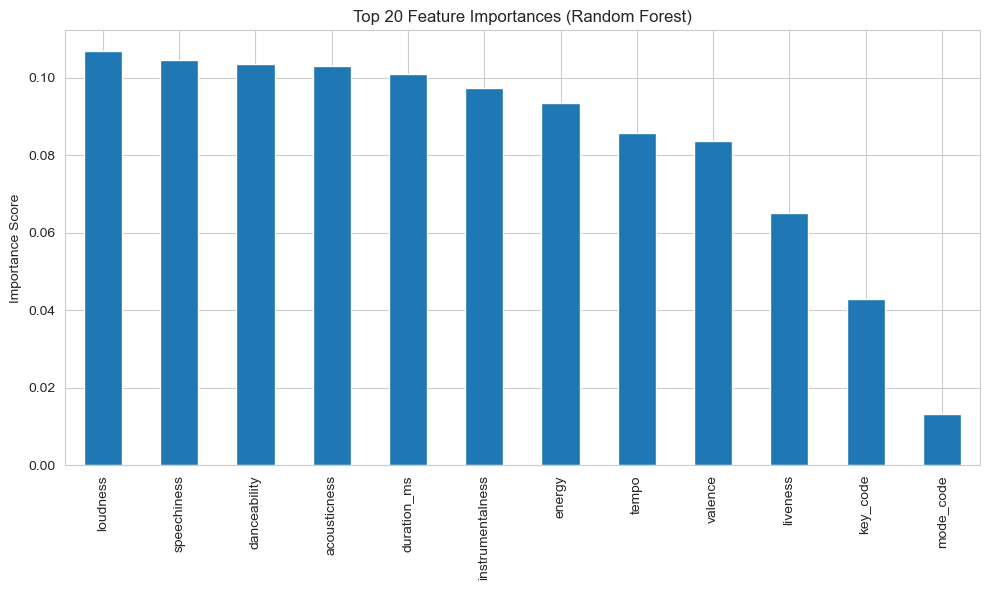

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

rf_imp = RandomForestClassifier(n_estimators=500, random_state=42)
rf_imp.fit(X_train[feature_sets["All_plus_interactions"]], y_train_enc)

importances = pd.Series(
    rf_imp.feature_importances_,
    index=feature_sets["All_plus_interactions"]
).sort_values(ascending=False)

print("=== 前20个重要特征 ===")
print(importances.head(20))

plt.figure(figsize=(10, 6))
importances.head(20).plot(kind="bar")
plt.title("Ranking of Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

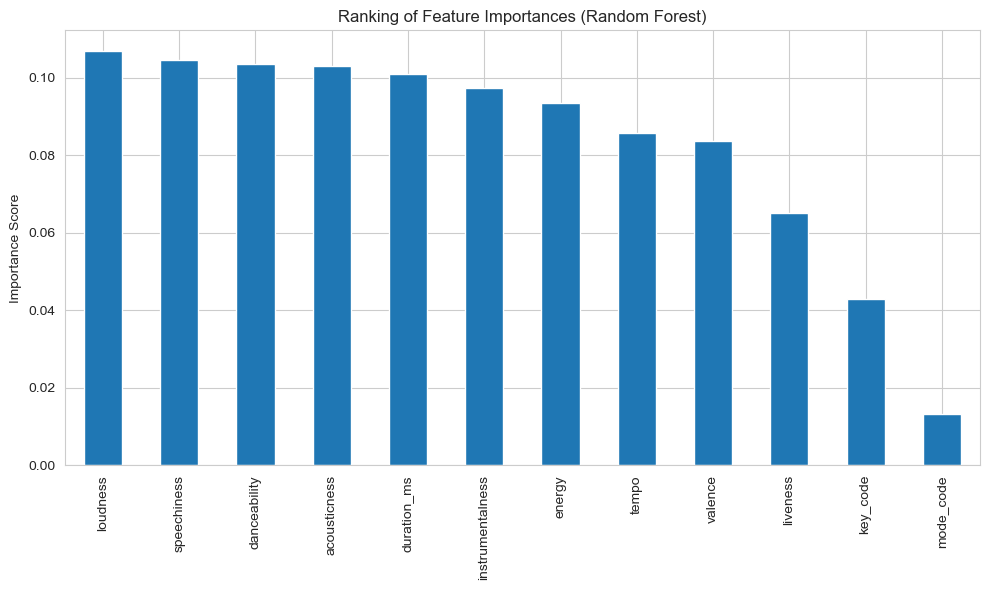

In [83]:
plt.figure(figsize=(10, 6))
importances.head(20).plot(kind="bar")
plt.title("Ranking of Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [75]:
df_model = results_df[results_df['FeatureSet'] == 'All']
df_model

,FeatureSet,Model,Val_Accuracy,Val_Precision_macro,Val_Recall_macro,Val_F1_macro,Test_Accuracy,Test_Precision_macro,Test_Recall_macro,Test_F1_macro
1,All,XGBoost,0.537067,0.532516,0.537067,0.532539,0.547600,0.542888,0.547600,0.543592
2,All,Random Forest,0.479600,0.468289,0.479600,0.471736,0.479333,0.468953,0.479333,0.471945
5,All,SVM,0.450400,0.439555,0.450400,0.436124,0.455867,0.446962,0.455867,0.442913
7,All,Neural Network (MLP),0.447467,0.436026,0.447467,0.435421,0.448667,0.440044,0.448667,0.437837
10,All,Logistic Regression,0.396400,0.384230,0.396400,0.383414,0.393067,0.386544,0.393067,0.383792
13,All,KNN,0.367467,0.370713,0.367467,0.365195,0.366667,0.367090,0.366667,0.362545


In [112]:
pivot_df = results_df.pivot(index='FeatureSet', columns='Model', values='Test_F1_macro')
df1 = pivot_df.T
df1 = df1.drop(columns = ["All_plus_interactions"])
df1

FeatureSet,All,Core_Audio,Rhythm
Model,,,
KNN,0.362545,0.293728,0.288388
Logistic Regression,0.383792,0.281747,0.270934
Neural Network (MLP),0.437837,0.361429,0.345973
Random Forest,0.471945,0.372686,0.346651
SVM,0.442913,0.346106,0.307601
XGBoost,0.543592,0.396699,0.391414


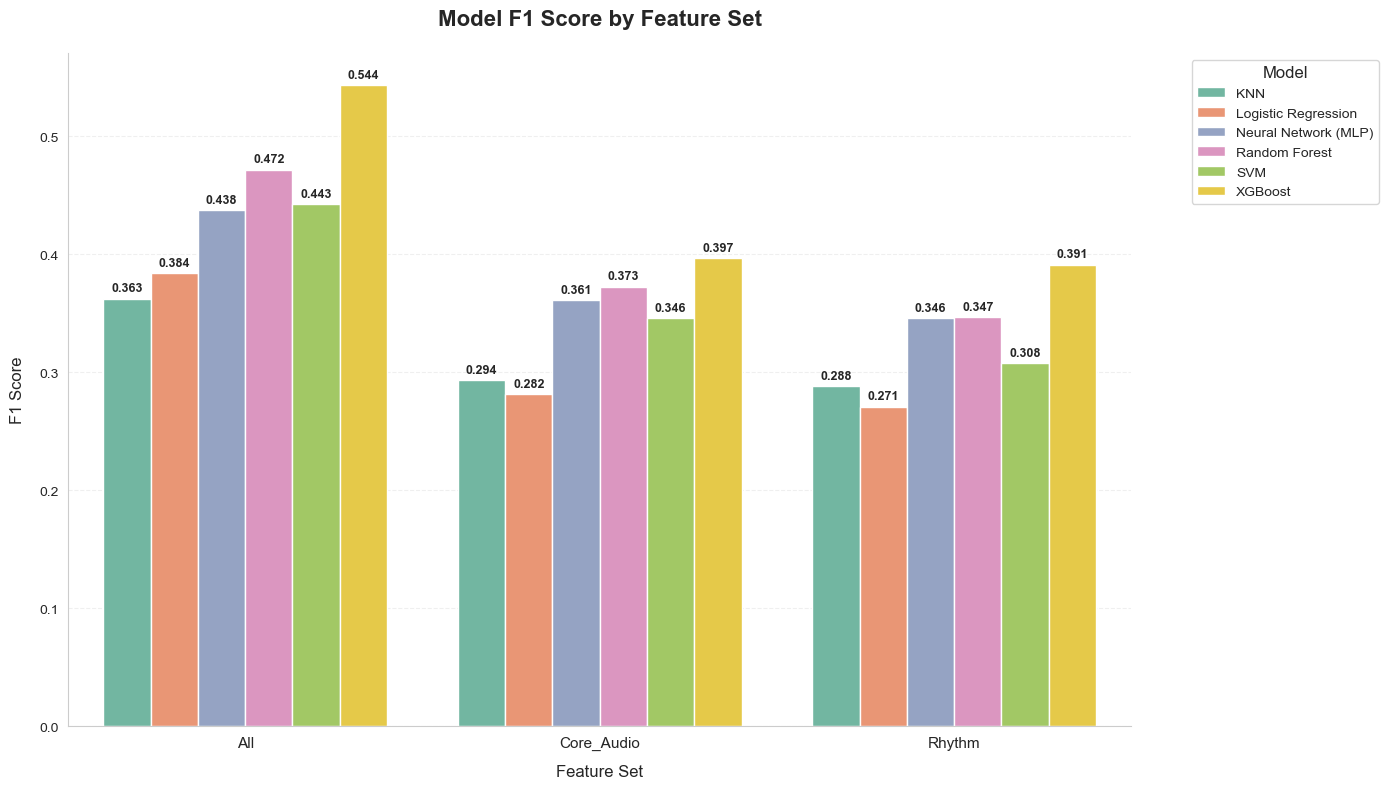

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pivot_df = pd.DataFrame({
    'All': [0.362545, 0.383792, 0.437837, 0.471945, 0.442913, 0.543592],
    'Core_Audio': [0.293728, 0.281747, 0.361429, 0.372686, 0.346106, 0.396699],
    'Rhythm': [0.288388, 0.270934, 0.345973, 0.346651, 0.307601, 0.391414]
}, index=['KNN', 'Logistic Regression', 'Neural Network (MLP)', 
          'Random Forest', 'SVM', 'XGBoost'])

df_long = pivot_df.reset_index().melt(id_vars='index', 
                                     value_vars=['All', 'Core_Audio', 'Rhythm'],
                                     var_name='FeatureSet', 
                                     value_name='Score')
df_long = df_long.rename(columns={'index': 'Model'})

plt.figure(figsize=(14, 8))
sns.barplot(data=df_long, x='FeatureSet', y='Score', hue='Model', 
            palette='Set2', order=['All', 'Core_Audio', 'Rhythm'])

plt.title('Model F1 Score by Feature Set', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Feature Set', fontsize=12, labelpad=10)
plt.ylabel('F1 Score', fontsize=12, labelpad=10)
plt.xticks(fontsize=11)

ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=9, fontweight='bold')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Model', 
           title_fontsize=12, fontsize=10, frameon=True, fancybox=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [98]:
df0 = df_model[["Model","Test_Accuracy","Test_Precision_macro","Test_Recall_macro","Test_F1_macro"]]
df0

,Model,Test_Accuracy,Test_Precision_macro,Test_Recall_macro,Test_F1_macro
1,XGBoost,0.547600,0.542888,0.547600,0.543592
2,Random Forest,0.479333,0.468953,0.479333,0.471945
5,SVM,0.455867,0.446962,0.455867,0.442913
7,Neural Network (MLP),0.448667,0.440044,0.448667,0.437837
10,Logistic Regression,0.393067,0.386544,0.393067,0.383792
13,KNN,0.366667,0.367090,0.366667,0.362545


<Figure size 1000x600 with 0 Axes>

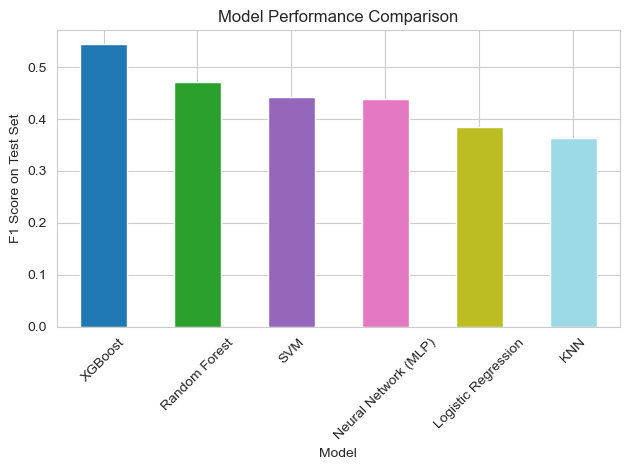

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(df_model))) 
df_model.plot.bar(x='Model', y='Test_F1_macro', color=colors, legend=False)
plt.title('Model Performance Comparison')
plt.ylabel('F1 Score on Test Set')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()